# RWTH Hack Mining 

## Track Drive Condition Monitoring of Mining Excavators (Komatsu)

## Overview: 

It is crucial to know the wear status of mining excavator track drives, because that helps to avoid costly unplanned downtime. To improve the current situation of risky and time-consuming manual geometric measurements, a concept of an automatic wear monitoring has been developed, that aims for detecting the wear during regular operation. As a proof of concept, a few hundred events were measured on a 550t-excavator and manually analyzed. Depending on the operating conditions, evaluation of different physical effects visible in sensor data allows conclusions to the current wear of the track drive. The task is to design an automatic algorithm to estimates the wear by evaluating the course of signals. To achieve that, toolboxes from Matlab (Signal Processing, Neural Network, Statistical) are to be applied. The outcome of the approaches should be validated by the manual evaluation results. To get you on track, an overview of the physics, videos and prepared sensor data will be provided. Take up the challenge and help make mining safer & smarter. Everyone, in particular students from engineering and computer science, is welcome. 


### 1. Import Relavent Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy import signal

### 2.  Data Pre Processing
#### 2.1 Import Data using Pandas

note: change the file path on your system

In [10]:
#get the data overview
data_path = '/Users/karenlee/Documents/VS_code/Hackkthon/data/Track_wear_m06_spot_turn.xlsx'
df = pd.read_excel(data_path , engine = 'openpyxl') 
df.head()

,Zeit -,n_sprocket_left - U/min,x_sprocket_left - mm,torque_travel_left - Nm,torque_travel_right - Nm,p_track_tension_left - bar,p_track_tension_right - bar
0,0.000000,0.000034,0.000000,1.321088,0.250282,39.281631,52.370979
1,0.000833,0.000034,0.000003,1.382598,0.224518,39.274406,52.369591
2,0.001667,0.000034,0.000005,1.266326,0.267108,39.260303,52.369404
3,0.002500,0.000034,0.000008,1.197580,0.344828,39.264931,52.369606
4,0.003333,0.000034,0.000011,1.277175,0.299051,39.273117,52.369202


#### 2.2 Plot Data 

**2.2.1 Torque and RPM Separately**

In [348]:
x = df["Zeit - "]
y = df["n_sprocket_left - U/min"]
#z = df["torque_travel_left - Nm"]

#filter the extra E1,E2 (outlier)
def zero_crossing_detection(data_frame):

    zero_crossing_index = np.array([0])
    
    for data_sample in range(0,data_frame.size) :
       
        if data_sample == data_frame.size-1 : 
            
            zero_crossing_index = np.delete(zero_crossing_index, 0)
            
            return zero_crossing_index
        
        if ((data_frame.iloc[data_sample] <= 0) and (data_frame.iloc[data_sample+1] >= 0)) or ((data_frame.iloc[data_sample] >= 0) and (data_frame.iloc[data_sample+1] <= 0)) : 
            
            zero_crossing_index = np.append(zero_crossing_index , data_sample)

def index_check(index_list):
    peaks_index_list_filtered = [] 
    for i in torque_index_list:
        temp = [j for j in index_list if j < i]
        try:
            if any(k in index_list for k in temp):
                peaks_index_list_filtered.append(index_list.pop(0))
        except ValueError:
            pass
    return peaks_index_list_filtered

z = df["torque_travel_left - Nm"]
torque_GF = gaussian_filter1d(z, 50)
torque_GF_df = pd.DataFrame(torque_GF, columns = [' Torque_GF'] )
torque_GF = torque_GF_df[' Torque_GF']
torque_zero_crossing_index = zero_crossing_detection(torque_GF)

##Get RPM data
# smoothening
smooth = gaussian_filter1d(y, 20)
# compute derivatives
smooth_d1 = np.gradient(smooth)
smooth_d2 = np.gradient(smooth_d1)
smoothsmooth_d2 = gaussian_filter1d(smooth_d2, 50)
peaks, _ = find_peaks(smoothsmooth_d2,prominence=(0.0002,0.0005))# high peak
lowpeak, _ = find_peaks(-smoothsmooth_d2,prominence=(0.00035))#low peak 0.00032

##Get Torque data
# smoothening
smooth_torque = gaussian_filter1d(z, 5)
# compute derivatives
smooth_d1_torque = np.gradient(smooth_torque)
smooth_d2_torque = np.gradient(smooth_d1_torque)
smoothsmooth_d2_torque = gaussian_filter1d(smooth_d2_torque, 50)
peaks_torque, _ = find_peaks(smooth_d1_torque)

#only taking the first value of E1, E2 within the range
torque_index_list = torque_zero_crossing_index.tolist()
peaks_index_list = peaks.tolist()
lowpeak_index_list = lowpeak.tolist()

new_peak = index_check(peaks_index_list)
new_lowpeak = index_check(lowpeak_index_list)
print("Number of high peak (potential E1): ",len(new_peak), "  Number of low peak (potential E2): ",len(new_lowpeak))


47 23


**2.2.2 Plotting the data**

Text(0.5, 1.0, 'Noise Reduction on the Second Derivative of RPM Data')

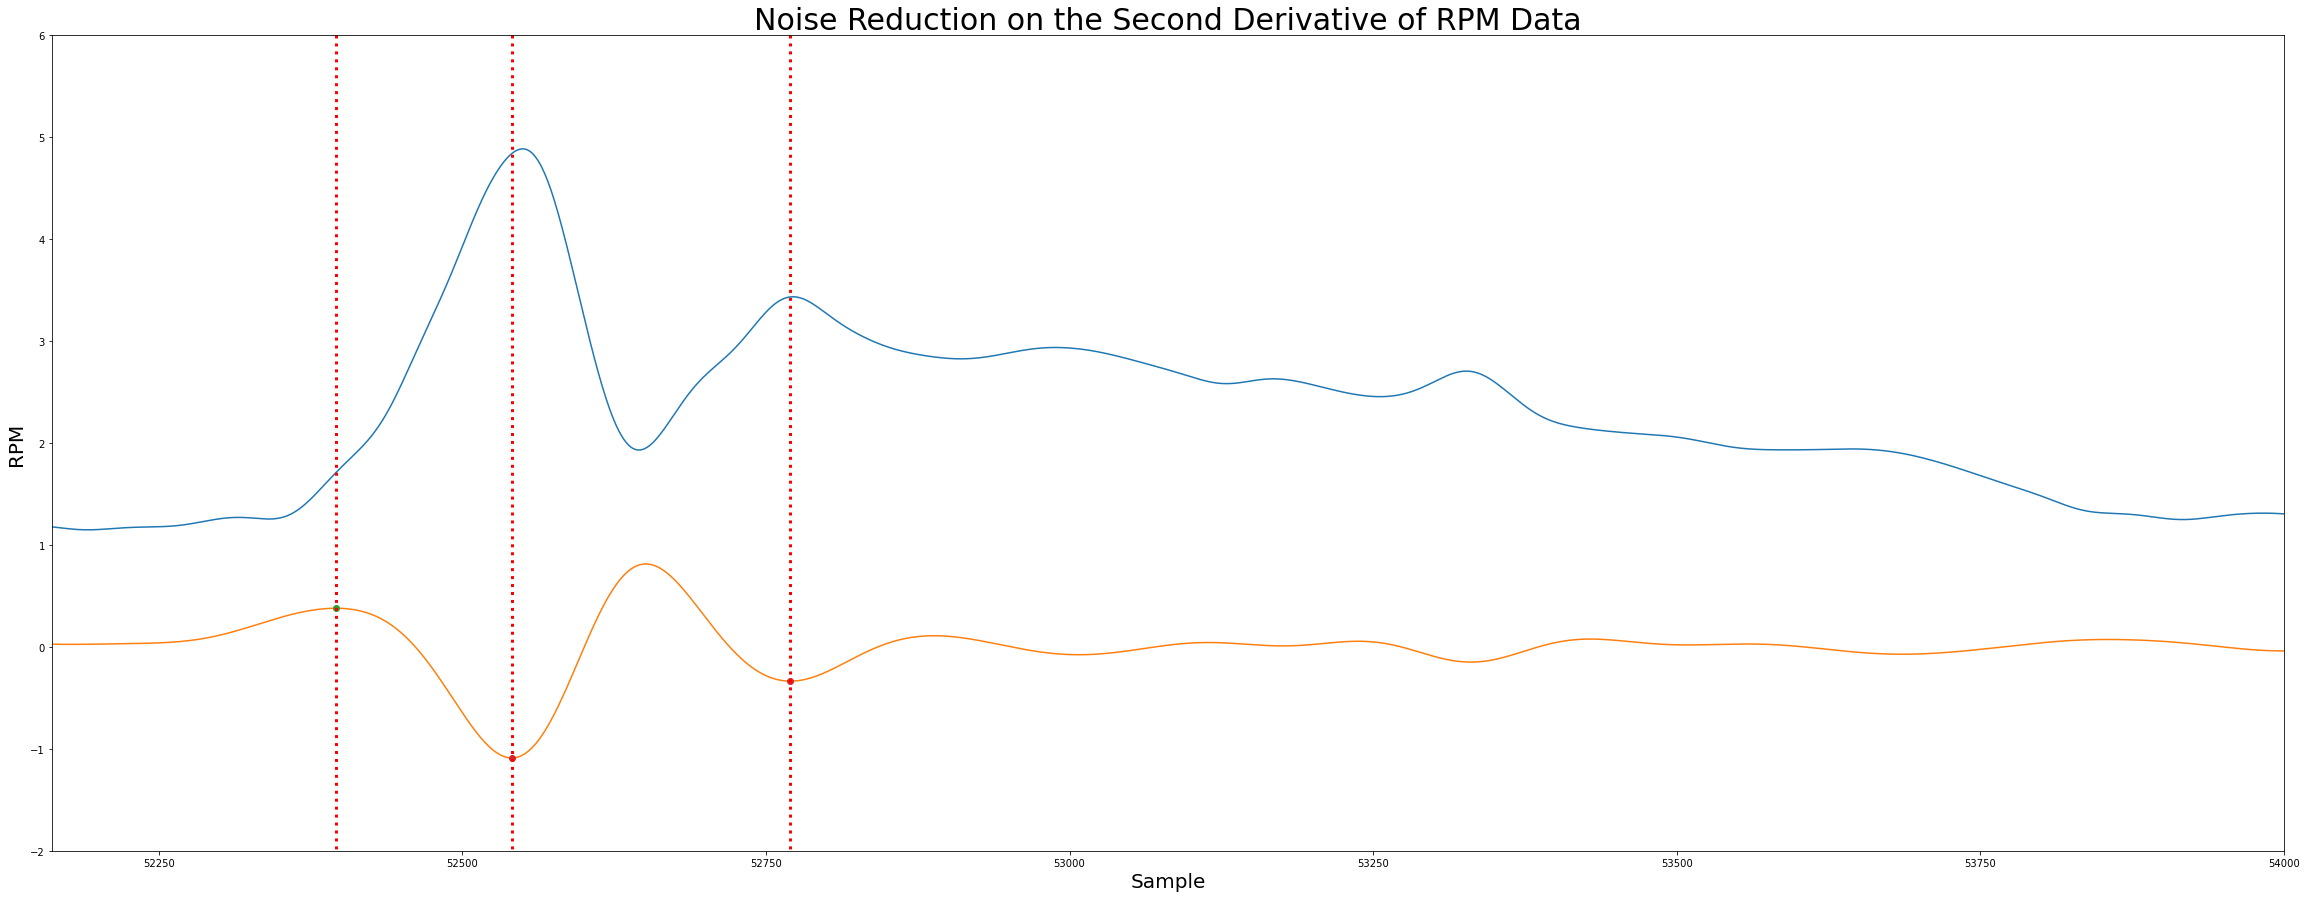

In [356]:
# plot results
plt.figure(figsize=(40, 15)) #size of plot

##rpm data plot
#plt.plot(y, label='Raw RPM Data') 
plt.plot(smooth, label='Smoothed RPM Data')
#plt.plot((smooth_d1 / np.max(smooth_d1)), label='First Derivative (scaled)')
#plt.plot((smooth_d2 / np.max(smooth_d2)), label='Second Derivative RPM')
plt.plot((smoothsmooth_d2 / np.max(smoothsmooth_d2)), label='Smoothened Second Derivative RPM')
plt.plot(new_peak,smoothsmooth_d2[new_peak]/np.max(smoothsmooth_d2),"o", label='High Peaks RPM') #all the E1
plt.plot(new_lowpeak,smoothsmooth_d2[new_lowpeak]/np.max(smoothsmooth_d2),"o", label='Low Peaks RPM') #all the E2

#torque data plot (To review the data)
#plt.plot(z, label='Torque Data') #original torque
#plt.plot(smooth_torque, label='Smoothed Torque Data')
#plt.plot((smooth_d1_torque / np.max(smooth_d1_torque)),label="First Derivative Torque Data",color="b")
#plt.plot((smooth_d2_torque / np.max(smooth_d2_torque)), label='Second Derivative Torque')
#plt.plot((smoothsmooth_d2_torque / np.max(smoothsmooth_d2_torque)), label='Smoothened Second Derivative Torque')
#plt.plot(peaks_torque,smooth_d1_torque[peaks_torque]/ np.max(smooth_d1_torque),"o", label='Peaks Torque')

#plot low peaks and high peaks in vertical line
#for i in range(len(torque_index_list)): #zero cross index line
#    plt.vlines(torque_index_list[i],6,-4, label='Torque',linewidth=3, color='b') #x, ymin, ymax
for i in range(len(new_lowpeak)): #E1 line
    plt.vlines(new_lowpeak[i],6,-4, label='E2',linewidth=3, color='red',linestyles='dotted') #x, ymin, ymax
for i in range(len(new_peak)): #E2 line
    plt.vlines(new_peak[i],6,-4, label='E1',linewidth=3, color='red',linestyles='dotted') #x, ymin, ymax

plt.axvspan(new_peak[1], new_lowpeak[0], alpha=0.5, color='pink') #fill the line in between #fill the gap

#zoom in to review the data set
plt.xlabel("Sample",fontsize=20) #axis labeling
plt.ylabel("RPM",fontsize=20)
#y-axis zomm
plt.ylim(-2, 6) 
#x-axis zomm
#plt.xlim(0,90000) 
#plt.xlim(0,20000) 
#plt.xlim(28000,32000) #first section sample
plt.xlim(52162, 54000)  #second secttion sample
#plt.xlim(67877, 78909) #third section sample
#plt.xlim(100000, 104000) #forth section sample
#plt.xlim(264000, 268000) 
#plt.xlim(190000,250000)

plt.title("Noise Reduction on the Second Derivative of RPM Data", fontsize=30)
#plt.legend()

Text(0.5, 0.98, 'Raw RPM & Torque Data')

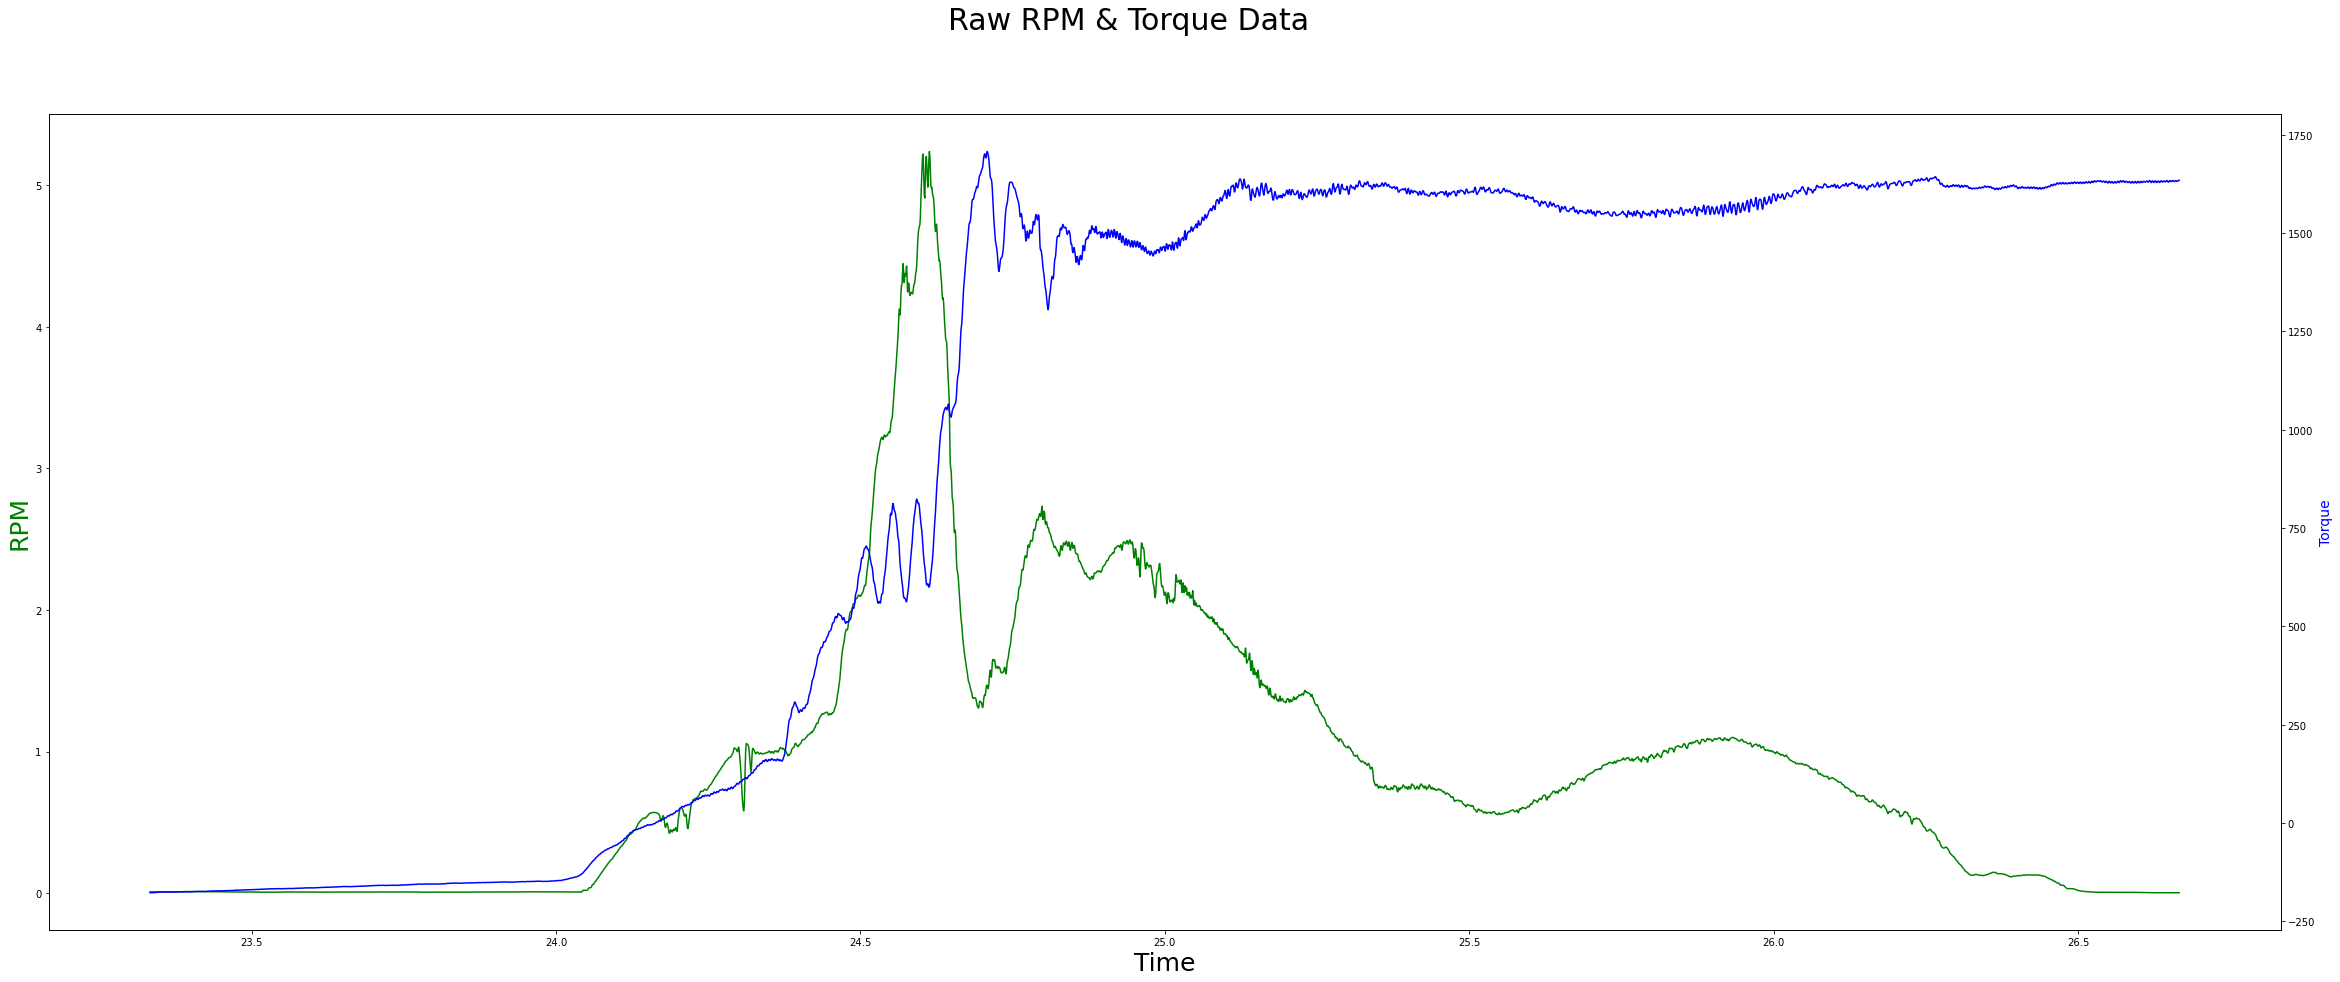

In [334]:
x1 = x[28000:32000]
y1_rpm = y[28000:32000]
y1_torque = z[28000:32000]

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(40, 15))
# make a plot
ax.plot(x1,y1_rpm,color="green")
# set x-axis label
ax.set_xlabel("Time", fontsize = 25)
# set y-axis label
ax.set_ylabel("RPM",color="green",fontsize=25)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x1, y1_torque ,color="blue")
ax2.set_ylabel("Torque",color="blue",fontsize=14)

fig.suptitle('Raw RPM & Torque Data', fontsize=30)

In [305]:
def estimate_slip(df , start_index , end_index, drum_diameter):
    
    pi = 3.142
    
    rps_data = (df["n_sprocket_left - U/min"].iloc[start_index:end_index])/60
    
    delta_t = df["Zeit - "].iloc[2] - df["Zeit - "].iloc[1]
    print(delta_t)
    
    arc_angle = np.sum(np.multiply(rps_data , delta_t)*2*pi)

    slip = arc_angle*(drum_diameter/2)
    
    return slip

start = peaks[1]
end = lowpeak[0]
diameter = 1554

results = estimate_slip(df, start, end,diameter)
print("Slip: ", round(results,4), "mm")

0.000833333333337
Slip:  34.8718 mm


## The review of data first set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


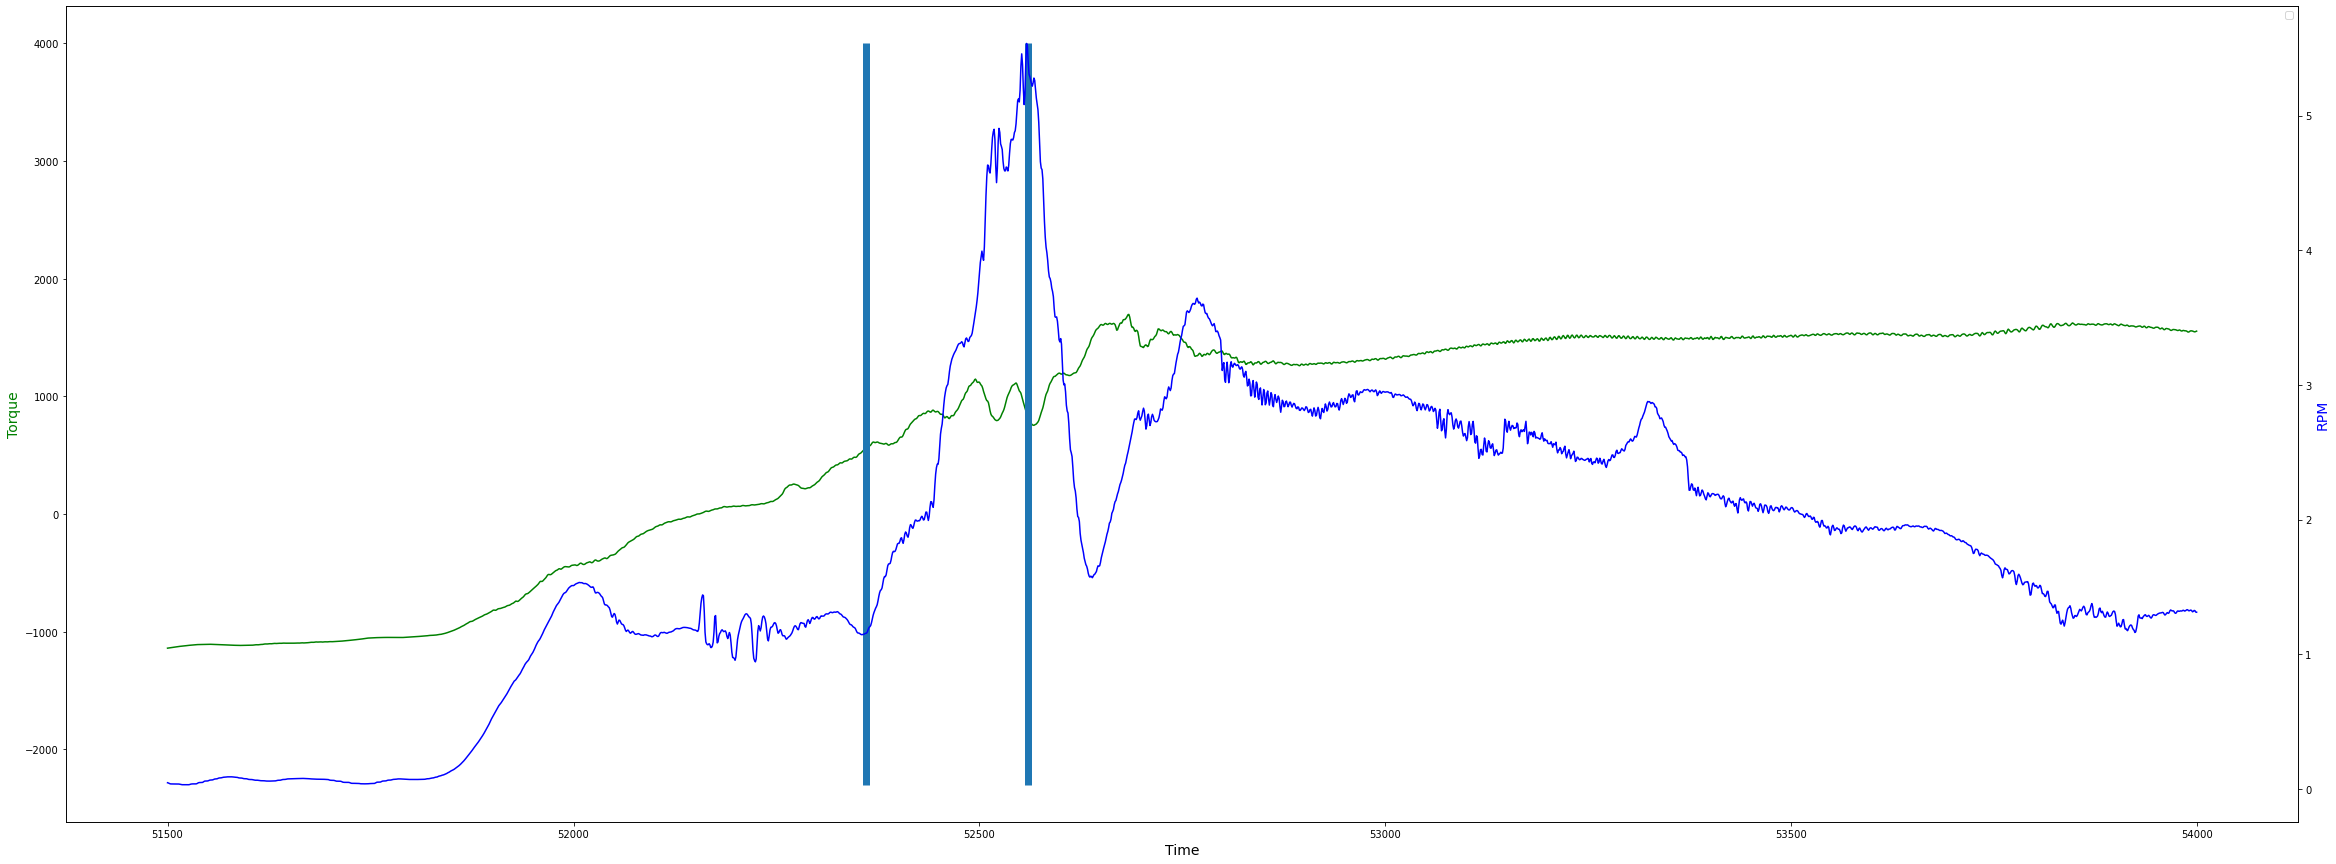

In [274]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (40,15))
# make a plot
ax.plot(z[51500:54000],color="green")
#ax.plot(x[51500:54000],z[51500:54000],color="green")
ax.vlines(52560,4000,-2300, label='E2',linewidth=7) #x, ymin, ymax
ax.vlines(52360,4000,-2300, label='E1',linewidth=7) #x, ymin, ymax

# set x-axis label
ax.set_xlabel("Time", fontsize = 14)
# set y-axis label
ax.set_ylabel("Torque",color="green",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(y[51500:54000] ,color="blue")
#ax2.plot(x[51500:54000], y[51500:54000] ,color="blue")
ax2.set_ylabel("RPM",color="blue",fontsize=14)
#ax.set_xlim([51500, 54000])


# only one line may be specified; full height
#ax.vlines(51500,0,3)
plt.legend()
plt.show()
